In [1]:
# Imports
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# for exporting to onnx
from brevitas.export import FINNManager

In [2]:
# transform PILImage images from dataset to tensors
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                         shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, 
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


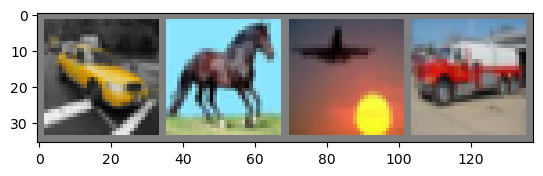

car   horse plane truck


In [3]:
# Just showing image for fun

def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# Get some random training image
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
# Define a Neural Network

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        # 2 convolution layers
        # 1 input image channel, 6 output channels, 5x5 convolution kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
        # Adding pooling layer here only this time
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # 3 fully connected layers
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        
    def forward(self, x):
        # Convolution layers
        # x is the input image to the Neural Network
        # Max pooling over a 2x2 window (since it is square, it can also be specified as 2, instead of (2,2))
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # Now applying flattening before passing it to the Fully Connected layers
        # flatten all dimensions except the batch dimension
        x = torch.flatten(x, 1)
        
        # Now the Fully Connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
net = Net()    

In [5]:
# Define a loss function (Cross-Entropy loss) and an optimizer (Stochastic Gradient Descent with momentum)
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [6]:
for epoch in range(2):
    
    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0): # enumerate used to put a counter with every data item
        inputs, labels = data
    
        optimizer.zero_grad()
    
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
        # print stats
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.882
[1,  4000] loss: 1.620
[1,  6000] loss: 1.537
[1,  8000] loss: 1.449
[1, 10000] loss: 1.421
[1, 12000] loss: 1.363
[2,  2000] loss: 1.297
[2,  4000] loss: 1.308
[2,  6000] loss: 1.294
[2,  8000] loss: 1.276
[2, 10000] loss: 1.264
[2, 12000] loss: 1.245
Finished Training


In [7]:
# Save the trained model
torch.save(net.state_dict(), './cifar_net.pth')

# Save using onnx format (for comparison)
FINNManager.export(net, input_shape=(1, 3, 32, 32), export_path='finn_lenet_non_quantized.onnx')

ir_version: 6
producer_name: "pytorch"
producer_version: "1.8"
graph {
  node {
    input: "input.1"
    input: "conv1.weight"
    input: "conv1.bias"
    output: "11"
    name: "Conv_0"
    op_type: "Conv"
    attribute {
      name: "dilations"
      ints: 1
      ints: 1
      type: INTS
    }
    attribute {
      name: "group"
      i: 1
      type: INT
    }
    attribute {
      name: "kernel_shape"
      ints: 5
      ints: 5
      type: INTS
    }
    attribute {
      name: "pads"
      ints: 0
      ints: 0
      ints: 0
      ints: 0
      type: INTS
    }
    attribute {
      name: "strides"
      ints: 1
      ints: 1
      type: INTS
    }
    domain: ""
  }
  node {
    input: "11"
    output: "12"
    name: "Relu_1"
    op_type: "Relu"
  }
  node {
    input: "12"
    output: "13"
    name: "MaxPool_2"
    op_type: "MaxPool"
    attribute {
      name: "kernel_shape"
      ints: 2
      ints: 2
      type: INTS
    }
    attribute {
      name: "pads"
      ints: 0
  

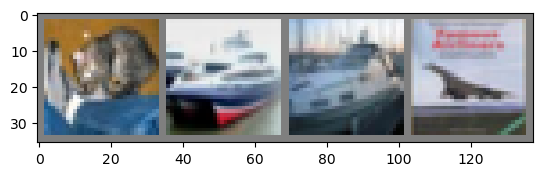

GroundTruth:  cat   ship  ship  plane


In [8]:
# Displaying an image from the test set
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [9]:
# Loading saved model from the file (not necessary in this case but just for illustration)
net = Net()
net.load_state_dict(torch.load('./cifar_net.pth'))


<All keys matched successfully>

In [10]:
# Check the prediction of the model on the trianing set
outputs = net(images)
_, predicted = torch.max(outputs, 1) # _ is to ignore first thing and 1 is given in max() for the 1st field (0 indexed)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   car   ship  plane


In [11]:
# Benchmarking the model over the whole dataset

correct = 0
total = 0

# Not calculating gradients as we are not training
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')        

Accuracy of the network on the 10000 test images: 54 %


In [12]:
# Calculating classwise accuracy

correct_pred = {classname: 0 for classname in classes} # set each class to 0 in the dictionary
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # count the correct and total predictions
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1 
            
# print the accuracy for each class 
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 54.1 %
Accuracy for class: car   is 63.6 %
Accuracy for class: bird  is 43.4 %
Accuracy for class: cat   is 52.7 %
Accuracy for class: deer  is 33.5 %
Accuracy for class: dog   is 39.1 %
Accuracy for class: frog  is 60.1 %
Accuracy for class: horse is 64.0 %
Accuracy for class: ship  is 67.4 %
Accuracy for class: truck is 63.5 %
